# UFA on Hansard for Language Change Chapter

This notebook produces the UFA analysis featured in the language change chapter.

**Need to move some of these methods into the fluctuation analysis module**

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import sqlite3
import regex as re

from datetime import datetime
from collections import Counter

from sklearn.preprocessing import StandardScaler
from nltk import ngrams as make_ngrams

In [2]:
GRAPH_DIR = "./Graphs"
out_dir = GRAPH_DIR

sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")
from settings import DB_FP

from helper_functions import split_corpus

In [3]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [4]:
sql_get_all_posts ="""
SELECT c.uid, m.name, m.PimsId, p.party, d.date, c.body, c.topic, c.section, s.tmay_deal, s.benn_act, s.ref_stance, s.constituency_leave, c.usas_file
FROM contributions as c
INNER JOIN members as m
ON m.PimsId = c.member
INNER JOIN debates as d
ON d.uid = c.debate
INNER JOIN member_party as p
ON p.PimsId = m.PimsId
INNER JOIN member_stances as s
ON s.PimsId = m.PimsId
WHERE (d.date BETWEEN date("2015-05-01") AND date("2019-12-11"))
AND (((d.date BETWEEN p.start AND p.end) AND NOT (p.end IS NULL))
OR ((d.date >= p.start) AND (p.end IS NULL)));""".strip()

In [5]:
from language_change_methods import vnc
from language_change_methods.utility_functions import tokenise
from language_change_methods.features import function_words

In [6]:
with open("../resources/speakers.json") as speaker_file:
    speaker_list = json.load(speaker_file)

In [7]:
%%time
conn = sqlite3.connect(DB_FP)
curs = conn.cursor()

# Gets all the contributions and creates a nice dataframe
all_contributions = pd.read_sql_query(sql_get_all_posts, conn)
all_contributions.columns = ['uid', 'name', 'PimsId', 'party', 'date', 'text', 'topic', 'section', 'tmay_deal', 'benn_act', 'ref_stance', 'constituency_leave', 'usas_file']
all_contributions.set_index("uid", inplace=True)
convert_to_date = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
all_contributions['date'] = all_contributions['date'].apply(convert_to_date)

all_contributions = all_contributions.query("PimsId not in @speaker_list")
all_contributions.sort_values("date", inplace=True)

# Tokenise the contributions
all_toks =  all_contributions["text"].apply(tokenise)

# Get the EU and Non-EU mentions
eu_mentions, non_eu_mentions = split_corpus(all_contributions, "eu")

Wall time: 3min 29s


# Code for Getting Collocates

In [8]:
from language_change_methods.utility_functions import get_data_windows

In [9]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

In [10]:
def get_collocate_window(doc, idx):
    if idx < 5:
        before = doc[:idx]
    else:
        before = doc[idx-5:idx]
    if idx > len(doc) - 5:
        after = doc[idx+1:]
    else:
        after = doc[idx+1:idx+6]
    return list(before) + list(after)

def count_document_collocates(search_tok, doc):
    collocates = []
    doc = np.array(doc)
    search_indices = np.where(doc == search_tok)[0]
    for idx in search_indices:
        collocates += get_collocate_window(doc, idx)
    return Counter(collocates)

def count_collocates(search_tok, toks, window_size=5):
    collocates = Counter()
    for doc in toks:
        collocates.update(count_document_collocates(search_tok, doc))
    return collocates

def tok_okay(tok):
    okay = True
    okay = okay and not re.match(r"[\p{P}|\p{S}|\p{N}]+", tok)
    okay = okay and tok.lower() not in function_words
    return okay

# Usage Fluctuation Analysis

In [11]:
def calc_ac1(t1, t2):
    a = (t1 & t2).sum()
    b = t1.sum() - a
    c = t2.sum() - a
    d = (~(t1 | t2)).sum()
    f = 2 * ((a + b + a + c)/(2*(a + b + c + d))) * (1 - (a + b + a + c)/(2*(a + b + c + d)))
    agree = (a + d) / (a + b + c + d)
    ac1 = (agree - f) / (1 - f)
    return ac1

In [12]:
def fluct_anal(collocates_over_time, comparison_function):
    comparisons = dict()
    for i in range(1, collocates_over_time.shape[0]):
        win_time = collocates_over_time.index[i]
        win_coll = collocates_over_time.iloc[i]
        pre_coll = collocates_over_time.iloc[i-1]
        comparisons[win_time] = comparison_function(pre_coll, win_coll)

    return pd.Series(comparisons)

In [13]:
def coll_mi(n_toks, node_freq, coll_freq, node_coll_freq):
    return np.log2(node_coll_freq / ((node_freq * coll_freq) / n_toks))

def coll_lr(n_toks, node_freq, coll_freq, node_coll_freq):
    return np.log2((node_coll_freq * (n_toks - node_freq)) / ((coll_freq - node_coll_freq) * node_freq))

In [14]:
def get_collocates_over_time(query, contributions, tokens, win_size, win_step, 
                             measure=coll_mi, threshold=3, min_freq=5, group_idxs=None):
    coll_over_time = dict()
    start_time = datetime.now()
    for win_time, win_posts in get_data_windows(contributions, win_size, win_step, time_column="date"):
        if group_idxs is not None:
            win_posts = win_posts[win_posts.index.isin(group_idxs)]
        
        # Get the tokens for this window
        win_toks = tokens[tokens.index.isin(win_posts.index)]
        
        # Get the counts for the current window
        win_counts = Counter(merge_lists(win_toks))
        
        # Get all collocates of search term at this time interval
        win_colls = count_collocates(query, win_toks)
        
        # Convert to a pandas series for easier processing
        win_colls = pd.Series(win_colls)
        
        # Remove all stop words (this is optional)
        win_colls = win_colls[win_colls.index.to_series().apply(tok_okay)]
        
        # Filter out collocates that are not common enough
        win_colls = win_colls[win_colls > min_freq]
        
        # Calculate the association measure for each collocate
        calc_measure = lambda x: measure(sum(win_counts.values()), win_counts[query], win_counts[x], win_colls[x])
        scores = win_colls.index.to_series().apply(calc_measure)
        scores = scores[scores > threshold]
        
        # Add this to the dict
        coll_over_time[win_time] = scores
#         print(datetime.now() - start_time)
        start_time = datetime.now()
        
    coll_over_time = pd.Series(coll_over_time)
    return coll_over_time

# Running the Bastard

In [15]:
search_term = "single"

In [16]:
%%time
coll_over_time = get_collocates_over_time(search_term, all_contributions, all_toks, 50000, 5000)

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]


Wall time: 1min 37s


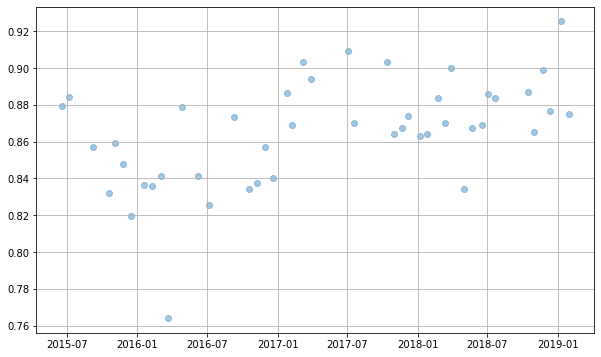

Wall time: 323 ms


In [17]:
%%time
# Make a collocate matrix
fig, ax = plt.subplots(figsize=(10,6))
threshold=0
coll_df = coll_over_time.apply(lambda x: x[x > threshold]).fillna(0)
coll_df = coll_df.applymap(lambda x: True if x > 0 else False)

fluct = fluct_anal(coll_df, calc_ac1)
# ax.plot(fluct)
ax.scatter(fluct.index, fluct.values, alpha=0.4)
ax.grid()
plt.show()

In [20]:
from language_change_methods.fluctuation_analysis import plot_gam_of_series

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


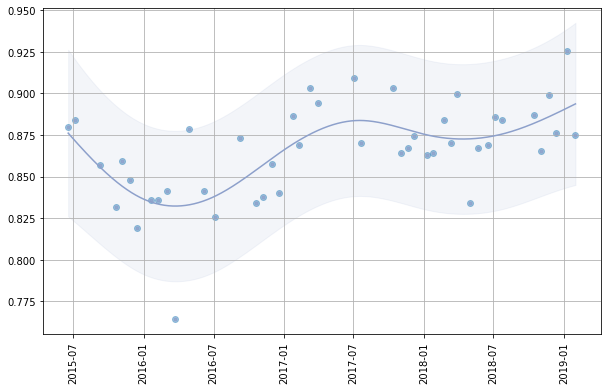

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(fluct.index, fluct.values, alpha=0.4)

plot_gam_of_series(fluct, ax)

ax.grid()
plt.show()

### Spearman Ranks

In [22]:
from nltk.metrics.spearman import ranks_from_scores, spearman_correlation

In [23]:
ranks_over_time = coll_over_time.apply(lambda row: list(ranks_from_scores([(i, x) for i, x in row.items()])))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


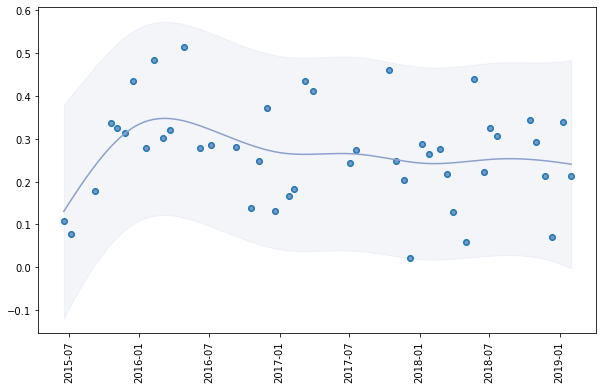

Wall time: 232 ms


In [24]:
%%time
# Make a collocate matrix
fig, ax = plt.subplots(figsize=(10,6))
fluct = fluct_anal(ranks_over_time , spearman_correlation)
ax.scatter(fluct.index, fluct.values)
plot_gam_of_series(fluct, ax)
plt.show()

# Comparing Groups with UFA

In [25]:
def plot_coll_over_time(search_term, contributions, tokens, win_size, win_step, 
                        group_idxs=None, colour=None, label=None, ax=None):
    # calculate scores for the collocates
    coll_over_time = get_collocates_over_time(search_term, contributions, tokens, win_size, win_step, 
                                              group_idxs=group_idxs)
    
    # Make a collocate matrix
    coll_df = coll_over_time.apply(lambda x: x).fillna(0)
    coll_df = coll_df.applymap(lambda x: True if x > 0 else False)
    
    # Calculate the fluctuation
    fluct = fluct_anal(coll_df, calc_ac1)
    
    # Make the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color=colour)
    plot_gam_of_series(fluct, ax, line_colour=colour, label=label)

    ax.grid()

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Wall time: 1min 37s


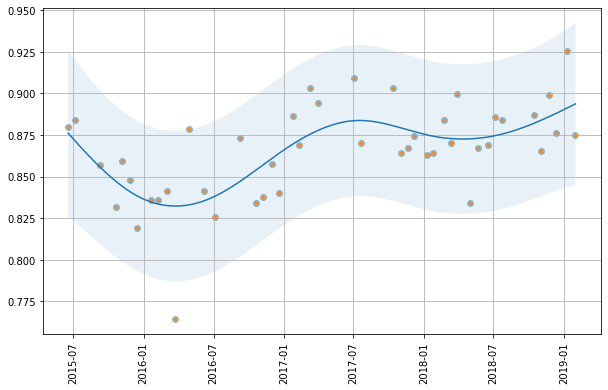

In [26]:
%%time
plot_coll_over_time("single", all_contributions, all_toks, 50000, 5000)

In [27]:
con = all_contributions[all_contributions["party"]=="Conservative"]
lab = all_contributions[all_contributions["party"]=="Labour"]

print("{0:12}: {1:10}".format("Conservative", con.shape[0]))
print("{0:12}: {1:10}".format("Labour", lab.shape[0]))

Conservative:     169568
Labour      :      70178


In [28]:
rem = all_contributions[all_contributions["ref_stance"]=="remain"]
lea = all_contributions[all_contributions["ref_stance"]=="leave"]

print("{0:12}: {1:10}".format("Remain", rem.shape[0]))
print("{0:12}: {1:10}".format("Leave", lea.shape[0]))

Remain      :     189926
Leave       :      64046


### Different windows for each group

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


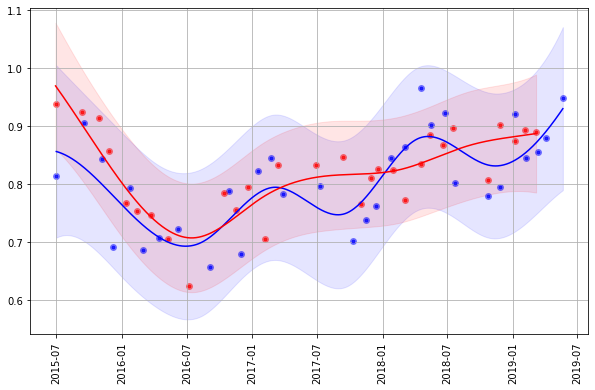

Wall time: 27 s


In [29]:
%%time
fig, ax = plt.subplots(figsize=(10,6))

search_term = "single"
plot_coll_over_time(search_term, con, all_toks.loc[con.index], 10000, 5000, colour="blue", label="Conservative", ax=ax)
plot_coll_over_time(search_term, lab, all_toks.loc[lab.index], 10000, 2000, colour="red", label="Labour", ax=ax)

ax.grid()
plt.show()

### Shared windows

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


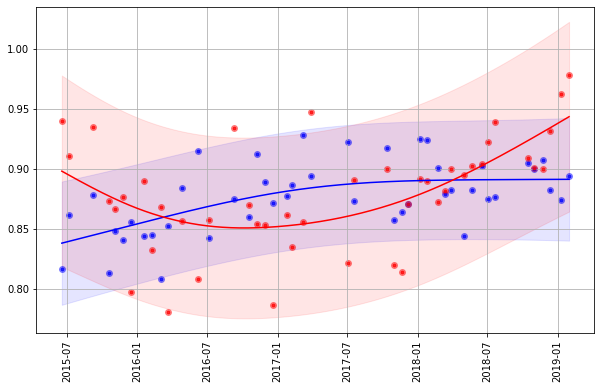

Wall time: 1min 25s


In [30]:
%%time
fig, ax = plt.subplots(figsize=(10,6))

search_term = "single"
plot_coll_over_time(search_term, all_contributions, all_toks.loc[con.index], 50000, 5000, 
                    group_idxs=con.index, colour="blue", label="Conservative", ax=ax)
plot_coll_over_time(search_term, all_contributions, all_toks.loc[lab.index], 50000, 5000, 
                    group_idxs=lab.index, colour="red", label="Labour", ax=ax)

ax.grid()
plt.show()

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


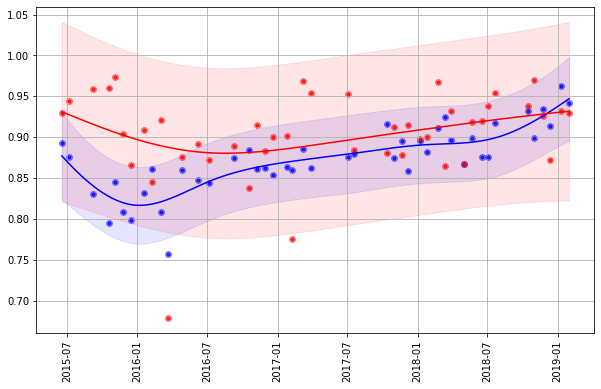

Wall time: 1min 30s


In [31]:
%%time
fig, ax = plt.subplots(figsize=(10,6))

search_term = "single"
plot_coll_over_time(search_term, all_contributions, all_toks.loc[rem.index], 50000, 5000, 
                    group_idxs=rem.index, colour="blue", label="Remain", ax=ax)
plot_coll_over_time(search_term, all_contributions, all_toks.loc[lea.index], 50000, 5000, 
                    group_idxs=lea.index, colour="red", label="Leave", ax=ax)

ax.grid()
plt.show()

## Testing Group Comparison

In [32]:
%%time
coll1 = get_collocates_over_time("single", all_contributions, all_toks, 20000, 20000, 
                                              group_idxs=con.index)

coll2 = get_collocates_over_time("single", all_contributions, all_toks, 20000, 20000, 
                                              group_idxs=lab.index)

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]


Wall time: 9.93 s


In [33]:
def make_df(colls):
    coll_df = colls.apply(lambda x: x).fillna(0)
    coll_df = coll_df.applymap(lambda x: True if x > 0 else False)
    return coll_df

In [36]:
df1 = make_df(coll1)
df2 = make_df(coll2)

In [37]:
from language_change_methods.fluctuation_analysis import add_missing_columns, make_dfs_comparable

In [38]:
df1, df2 = make_dfs_comparable(df1, df2, fill_value=False)

In [41]:
from language_change_methods.fluctuation_analysis import comp_anal

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


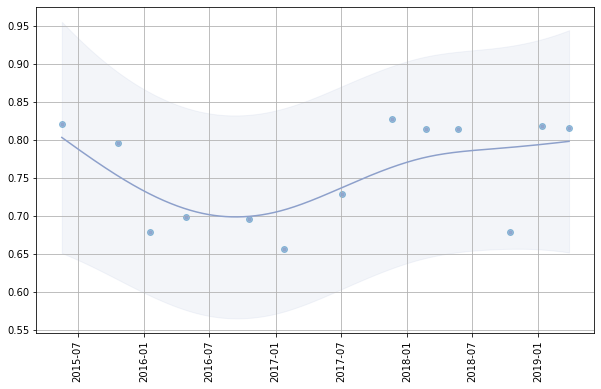

In [42]:
# Make a collocate matrix
fig, ax = plt.subplots(figsize=(10,6))

fluct = comp_anal(df1, df2, calc_ac1)
ax.scatter(fluct.index, fluct.values, alpha=0.4)
plot_gam_of_series(fluct, ax)

ax.grid()
plt.show()

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


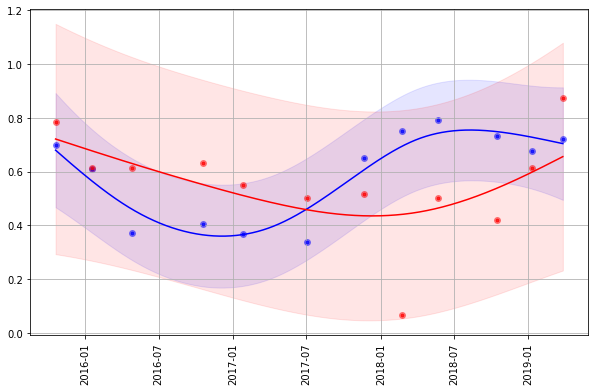

Wall time: 10.8 s


In [43]:
%%time
fig, ax = plt.subplots(figsize=(10,6))

search_term = "single"
plot_coll_over_time(search_term, all_contributions, all_toks.loc[rem.index], 20000, 20000, 
                    group_idxs=rem.index, colour="blue", label="Remain", ax=ax)
plot_coll_over_time(search_term, all_contributions, all_toks.loc[lea.index], 20000, 20000, 
                    group_idxs=lea.index, colour="red", label="Leave", ax=ax)

ax.grid()
plt.show()

# Some Examples for the Paper

In [44]:
%%time
ufa_examples = dict()

for search_term in ["eu", "brexit", "deal", "single", "customs"]:
    # calculate scores for the collocates
    ufa_examples[search_term] = get_collocates_over_time(search_term, all_contributions, all_toks, 
                                                         50000, 10000, group_idxs=None)

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]


Wall time: 4min 14s


In [45]:
def calculate_flucts(coll_over_time):
    # Make a collocate matrix
    coll_df = coll_over_time.apply(lambda x: x).fillna(0)
    coll_df = coll_df.applymap(lambda x: True if x > 0 else False)

    # Calculate the fluctuation
    fluct = fluct_anal(coll_df, calc_ac1)
    return fluct

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


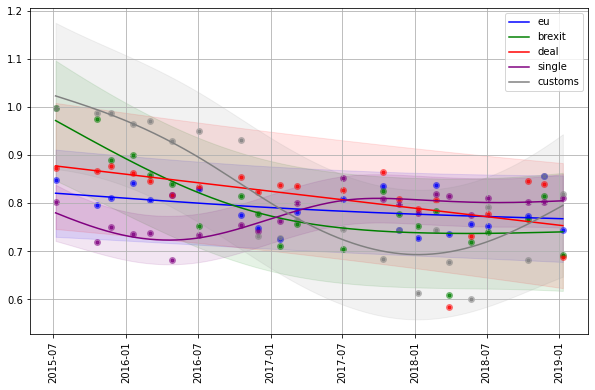

In [46]:
# Make the plot
fig, ax = plt.subplots(figsize=(10,6))
colours = ["blue", "green", "red", "purple", "grey"]
for i, w in enumerate(ufa_examples):
    fluct = calculate_flucts(ufa_examples[w])
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color=colours[i])
    plot_gam_of_series(fluct, ax, line_colour=colours[i], label=w)

ax.grid()
ax.legend()
plt.show()

In [47]:
%%time
ufa_eu_examples = dict()

for search_term in ["eu", "brexit", "deal", "single", "customs"]:
    # calculate scores for the collocates
    ufa_eu_examples[search_term] = get_collocates_over_time(search_term, eu_mentions, all_toks,
                                                            10000, 2000, group_idxs=None)

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]


Wall time: 1min 15s


## Need to suck the spacing out of this graph

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


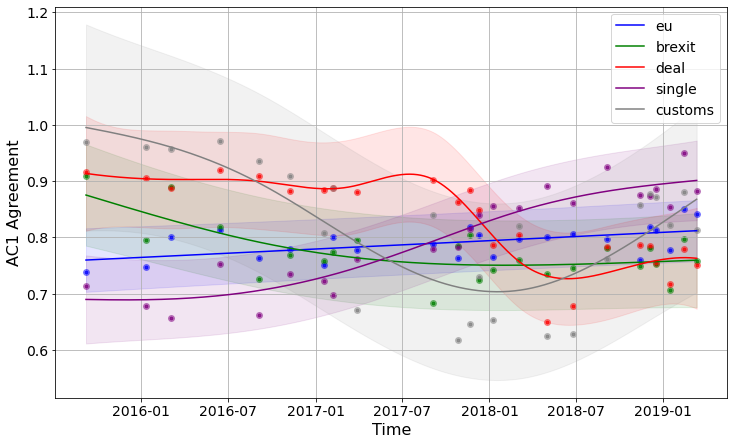

In [48]:
# Make the plot
fig, ax = plt.subplots(figsize=(10,6))
colours = ["blue", "green", "red", "purple", "grey"]
for i, w in enumerate(ufa_eu_examples):
    fluct = calculate_flucts(ufa_eu_examples[w])
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color=colours[i])
    plot_gam_of_series(fluct, ax, line_colour=colours[i], label=w)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.grid()
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("AC1 Agreement", fontsize=16)
ax.legend(fontsize=14)
plt.tight_layout(pad=0)
fig.savefig(os.path.join(GRAPH_DIR, "ufa_eu_examples.pdf"))
plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


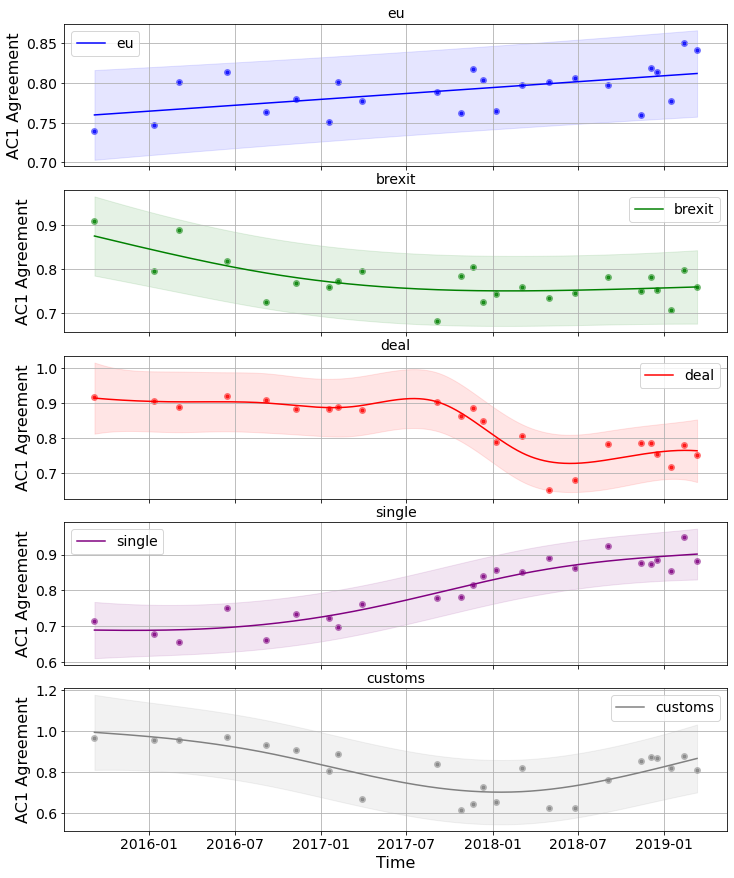

In [49]:
# Make the plot
fig, axes = plt.subplots(5, figsize=(10,12), sharex=True)
colours = ["blue", "green", "red", "purple", "grey"]
for i, w in enumerate(ufa_eu_examples):
    fluct = calculate_flucts(ufa_eu_examples[w])
    axes[i].scatter(fluct.index, fluct.values, alpha=0.4, color=colours[i])
    plot_gam_of_series(fluct, axes[i], line_colour=colours[i], label=w)
    axes[i].set_title(w, fontsize=14)
    axes[i].yaxis.set_tick_params(labelsize=14)
    axes[i].grid()
    axes[i].set_ylabel("AC1 Agreement", fontsize=16)
    axes[i].legend(fontsize=14)

    
axes[-1].xaxis.set_tick_params(labelsize=14, rotation=0)
axes[-1].set_xlabel("Time", fontsize=16)
# ax.legend(fontsize=14)
plt.tight_layout(pad=0)
fig.savefig(os.path.join(GRAPH_DIR, "ufa_eu_examples_2.pdf"))
plt.show()

In [50]:
for query in ufa_eu_examples:
    print(query)
    print("---------------------------------------")
    top_colls = ufa_eu_examples[query].apply(lambda x: x.sort_values(ascending=False).index[:10].values)
    for i, colls in top_colls.items():
        print(i.strftime("%Y-%m-%d"), end=",")
        print(",".join(colls))
    print("---------------------------------------")

eu
---------------------------------------
2015-05-27,nationals,ets,leaving,membership,prisoner,citizens,inefficiency,accounted,citizen,directives
2015-09-07,nationals,invaluable,resident,citizens,ets,citizen,leaving,directives,prisoner,membership
2016-01-12,nationals,exits,transpose,resident,citizens,leaving,ets,invaluable,directives,reside
2016-03-04,nationals,exits,transpose,resident,citizens,ets,leaving,invaluable,reside,directives
2016-06-14,nationals,residing,exits,transpose,citizens,resident,leaving,directives,leaves,derive
2016-09-05,nationals,residing,consolidated,enlargement,citizens,derive,directives,leaves,resident,leaving
2016-11-08,nationals,transposing,consolidated,residing,embargo,exits,enlargement,leaves,convert,retained
2017-01-19,ets,nationals,consolidated,residing,transposing,exits,retained,enlargement,embargo,leaves
2017-02-07,ets,converting,nationals,enlargement,exits,consolidated,retained,leaves,embargo,transposing
2017-03-29,ets,converting,nationals,exits,retain

In [51]:
for query in ufa_eu_examples:
    print(query)
    print("---------------------------------------")
    print(ufa_eu_examples[query].apply(len))
    print("---------------------------------------")

eu
---------------------------------------
2015-05-27    649
2015-09-07    637
2016-01-12    633
2016-03-04    603
2016-06-14    570
2016-09-05    593
2016-11-08    600
2017-01-19    597
2017-02-07    588
2017-03-29    629
2017-09-05    577
2017-10-26    607
2017-11-21    614
2017-12-11    616
2018-01-09    579
2018-03-05    545
2018-05-02    512
2018-06-25    555
2018-09-04    538
2018-11-13    566
2018-12-04    582
2018-12-17    562
2019-01-15    524
2019-02-13    506
2019-03-12    463
dtype: int64
---------------------------------------
brexit
---------------------------------------
2015-05-27     75
2015-09-07    143
2016-01-12    258
2016-03-04    298
2016-06-14    350
2016-09-05    385
2016-11-08    419
2017-01-19    396
2017-02-07    423
2017-03-29    408
2017-09-05    365
2017-10-26    380
2017-11-21    397
2017-12-11    389
2018-01-09    413
2018-03-05    409
2018-05-02    410
2018-06-25    438
2018-09-04    447
2018-11-13    438
2018-12-04    449
2018-12-17    431
2019-01-15 

## Comparing Groups in the Thesis

In [52]:
%%time
ufa_con_examples = dict()
ufa_lab_examples = dict()

for search_term in ["eu", "brexit", "deal", "single", "customs"]:
    # calculate scores for the collocates
    ufa_con_examples[search_term] = get_collocates_over_time(search_term, all_contributions, all_toks,
                                                                50000, 10000, group_idxs=con.index)
    
    ufa_lab_examples[search_term] = get_collocates_over_time(search_term, all_contributions, all_toks,
                                                                50000, 10000, group_idxs=lab.index)

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]


Wall time: 3min 40s


In [53]:
%%time
ufa_con_eu_examples = dict()
ufa_lab_eu_examples = dict()

for search_term in ["eu", "brexit", "deal", "single", "customs"]:
    # calculate scores for the collocates
    ufa_con_eu_examples[search_term] = get_collocates_over_time(search_term, eu_mentions, all_toks,
                                                                10000, 2000, group_idxs=con.index)
    
    ufa_lab_eu_examples[search_term] = get_collocates_over_time(search_term, eu_mentions, all_toks,
                                                                10000, 2000, group_idxs=lab.index)

<ipython-input-10-18d5fcccd736>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  search_indices = np.where(doc == search_tok)[0]


Wall time: 1min 3s


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


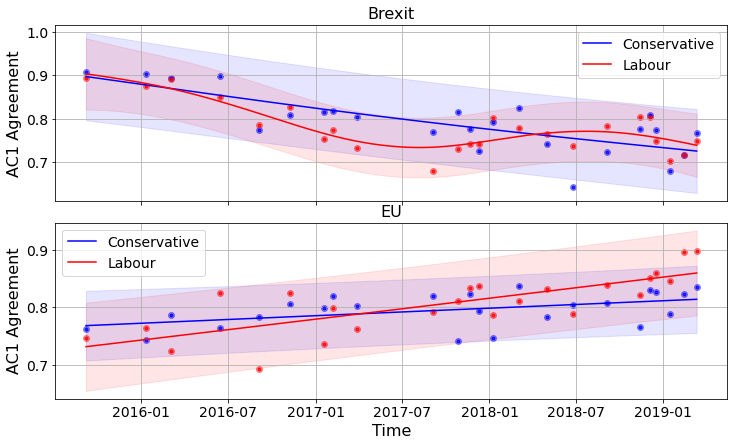

In [54]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6), sharex=True)

# First word (Brexit)
fluct = calculate_flucts(ufa_con_eu_examples["brexit"])
ax1.scatter(fluct.index, fluct.values, alpha=0.4, color="blue")
plot_gam_of_series(fluct, ax1, line_colour="blue", label="Conservative")

fluct = calculate_flucts(ufa_lab_eu_examples["brexit"])
ax1.scatter(fluct.index, fluct.values, alpha=0.4, color="red")
plot_gam_of_series(fluct, ax1, line_colour="red", label="Labour")

ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_ylabel("AC1 Agreement", fontsize=16)

ax1.set_title("Brexit", fontsize=16)
ax1.grid()
ax1.legend(fontsize=14)

# Second_word (EU)
fluct = calculate_flucts(ufa_con_eu_examples["eu"])
ax2.scatter(fluct.index, fluct.values, alpha=0.4, color="blue")
plot_gam_of_series(fluct, ax2, line_colour="blue", label="Conservative")

fluct = calculate_flucts(ufa_lab_eu_examples["eu"])
ax2.scatter(fluct.index, fluct.values, alpha=0.4, color="red")
plot_gam_of_series(fluct, ax2, line_colour="red", label="Labour")

ax2.xaxis.set_tick_params(labelsize=14, rotation=0)
ax2.yaxis.set_tick_params(labelsize=14)

ax2.set_xlabel("Time", fontsize=16)
ax2.set_ylabel("AC1 Agreement", fontsize=16)

ax2.set_title("EU", fontsize=16)
ax2.grid()
ax2.legend(fontsize=14)

plt.tight_layout(pad=0)
fig.savefig(os.path.join(GRAPH_DIR, "ufa_comparison.pdf"))

plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


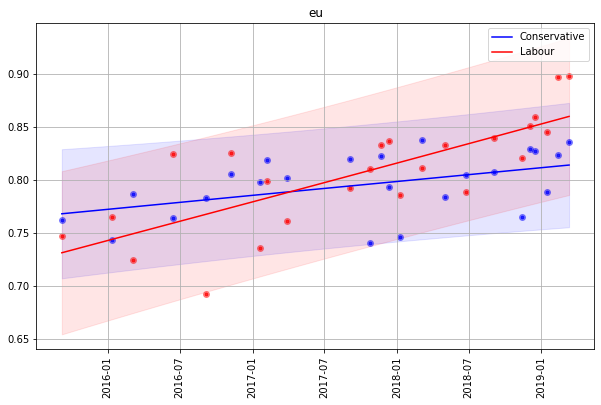

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


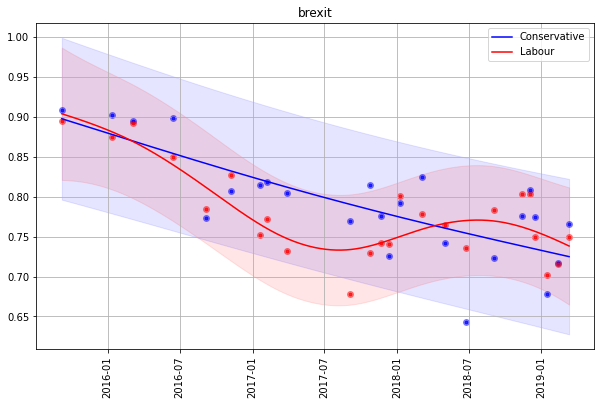

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


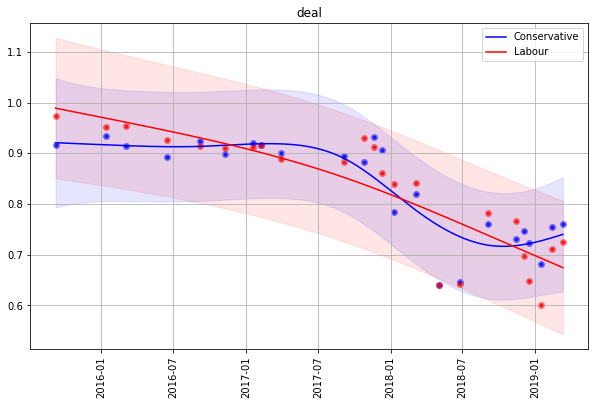

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


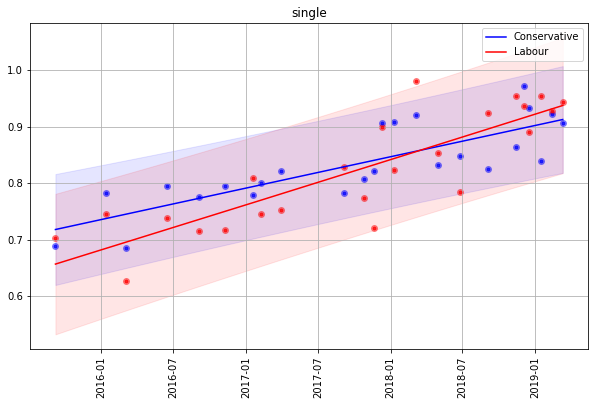

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


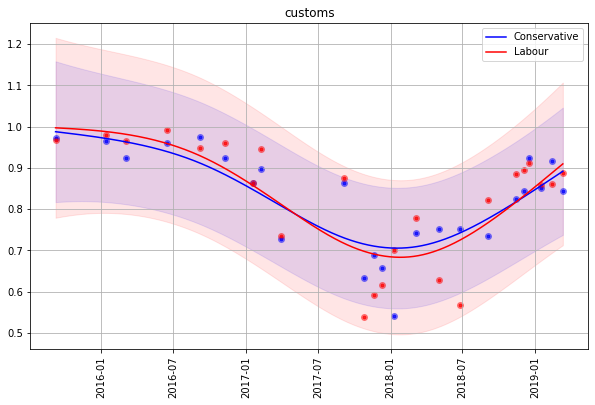

In [55]:
# Make the plot
colours = ["blue", "green", "red", "purple", "grey"]
for i, w in enumerate(ufa_eu_examples):
    fig, ax = plt.subplots(figsize=(10,6))

    fluct = calculate_flucts(ufa_con_eu_examples[w])
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color="blue")
    plot_gam_of_series(fluct, ax, line_colour="blue", label="Conservative")

    fluct = calculate_flucts(ufa_lab_eu_examples[w])
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color="red")
    plot_gam_of_series(fluct, ax, line_colour="red", label="Labour")
    
    ax.set_title(w)
    
    ax.grid()
    ax.legend()
    plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


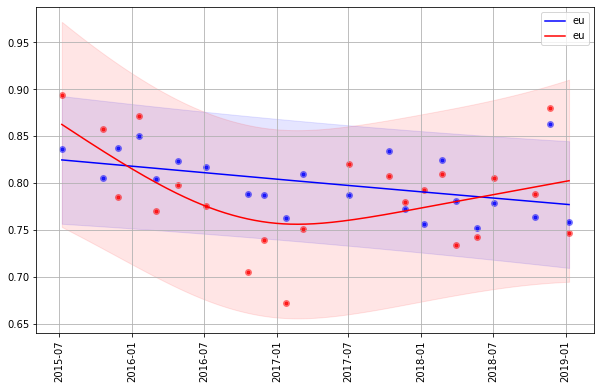

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


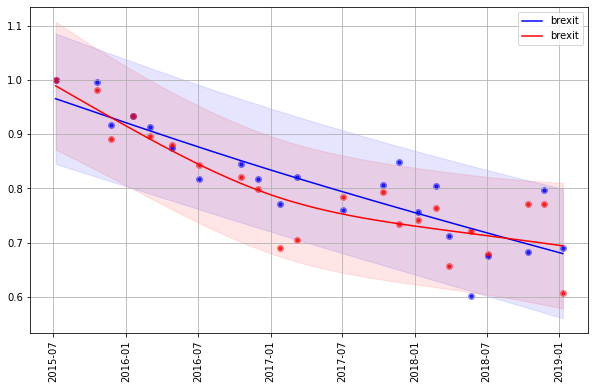

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


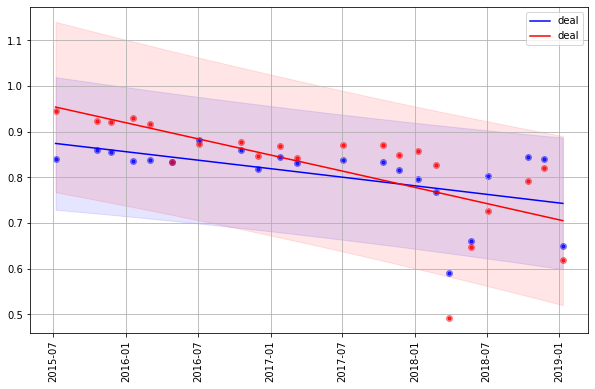

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


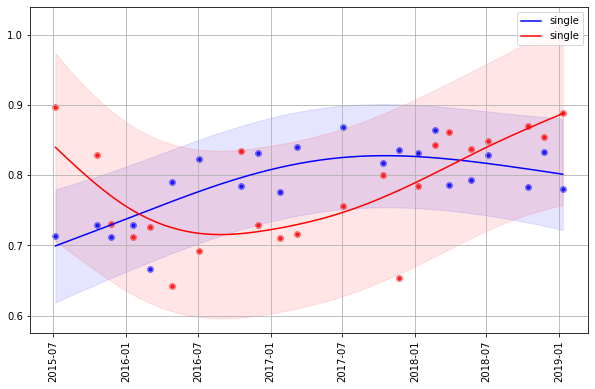

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


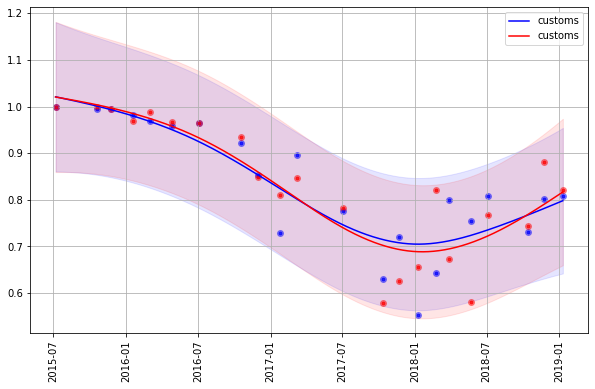

In [56]:
# Make the plot
colours = ["blue", "green", "red", "purple", "grey"]
for i, w in enumerate(ufa_con_examples):
    fig, ax = plt.subplots(figsize=(10,6))

    fluct = calculate_flucts(ufa_con_examples[w])
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color="blue")
    plot_gam_of_series(fluct, ax, line_colour="blue", label=w)

    fluct = calculate_flucts(ufa_lab_examples[w])
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color="red")
    plot_gam_of_series(fluct, ax, line_colour="red", label=w)
    
    ax.grid()
    ax.legend()
    plt.show()

In [57]:
query = "eu"
print(query)
print("---------------------------------------")
top_colls = ufa_con_eu_examples[query].apply(lambda x: x.sort_values(ascending=False).index[:10].values)
for i, colls in top_colls.items():
    print(i.strftime("%Y-%m-%d"), end=",")
    print(",".join(colls))
print("---------------------------------------")
top_colls = ufa_lab_eu_examples[query].apply(lambda x: x.sort_values(ascending=False).index[:10].values)
for i, colls in top_colls.items():
    print(i.strftime("%Y-%m-%d"), end=",")
    print(",".join(colls))
print("---------------------------------------")

eu
---------------------------------------
2015-05-27,nationals,citizen,prisoner,unwanted,directives,pro-,solidarity,leaving,submission,citizens
2015-09-07,nationals,citizen,prisoner,directives,citizens,pro-,solidarity,resident,leaves,leaving
2016-01-12,exits,nationals,directives,leaving,citizens,prisoner,leaves,citizen,solidarity,resident
2016-03-04,nationals,guaranteeing,directives,citizens,prisoner,leaving,resident,non-,leaves,citizen
2016-06-14,nationals,directives,leaves,guaranteeing,citizens,leaving,living,non-,resident,status
2016-09-05,nationals,consolidated,leaves,citizens,directives,convert,guaranteeing,leaving,living,non-
2016-11-08,nationals,consolidated,convert,retained,leaves,citizens,directives,rejoin,acquis,leaving
2017-01-19,consolidated,nationals,convert,retained,leaves,snapshot,citizens,directives,supremacy,arms
2017-02-07,nationals,consolidated,leaves,retained,convert,snapshot,supremacy,directives,citizens,leaving
2017-03-29,nationals,retained,leaves,snapshot,suprem